In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/Users/mateivolanschi/Desktop/project 2 /HousingPrices-Amsterdam-August-2021.csv')

In [3]:
data

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538
...,...,...,...,...,...,...,...,...
919,920,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173
920,921,"Kleine Beerstraat 31, Amsterdam",1033 CP,350000.0,72,3,4.890612,52.414587
921,922,"Stuyvesantstraat 33 II, Amsterdam",1058 AK,350000.0,51,3,4.856935,52.363256
922,923,"John Blankensteinstraat 51, Amsterdam",1095 MB,599000.0,113,4,4.965731,52.375268


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'Price'}>],
       [<AxesSubplot:title={'center':'Area'}>,
        <AxesSubplot:title={'center':'Room'}>],
       [<AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'Lat'}>]], dtype=object)

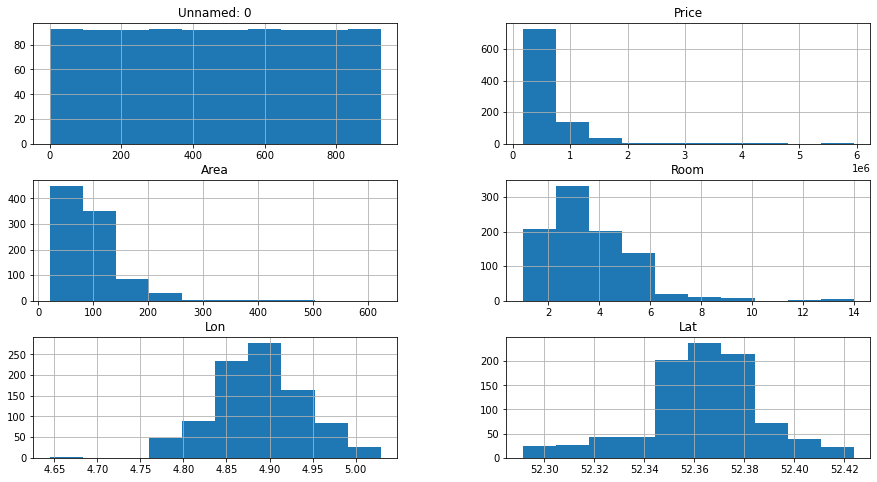

In [5]:
data.hist(figsize=(15,8))

<AxesSubplot:>

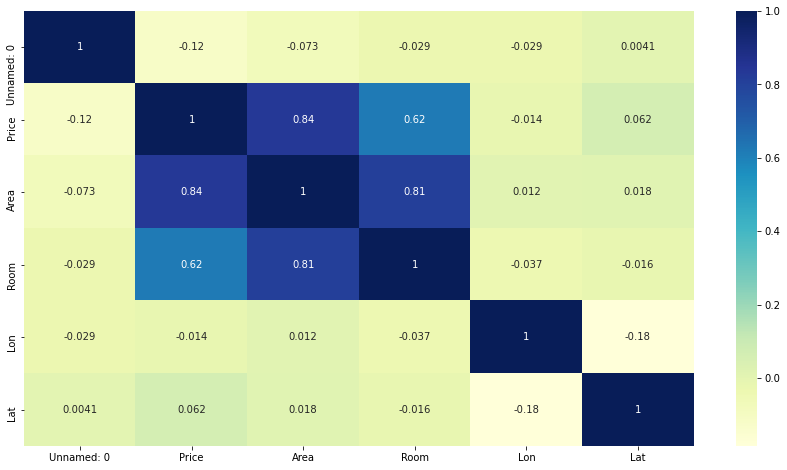

In [6]:
#see what features influence the price most
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")

In [7]:
# Encode zip codes by keeping only the numbers 
zip_codes = data['Zip']

encoded_zip_codes = zip_codes.str.replace(r'\D', '', regex=True).astype(int)

data['Zip'] = encoded_zip_codes

<AxesSubplot:xlabel='Lat', ylabel='Lon'>

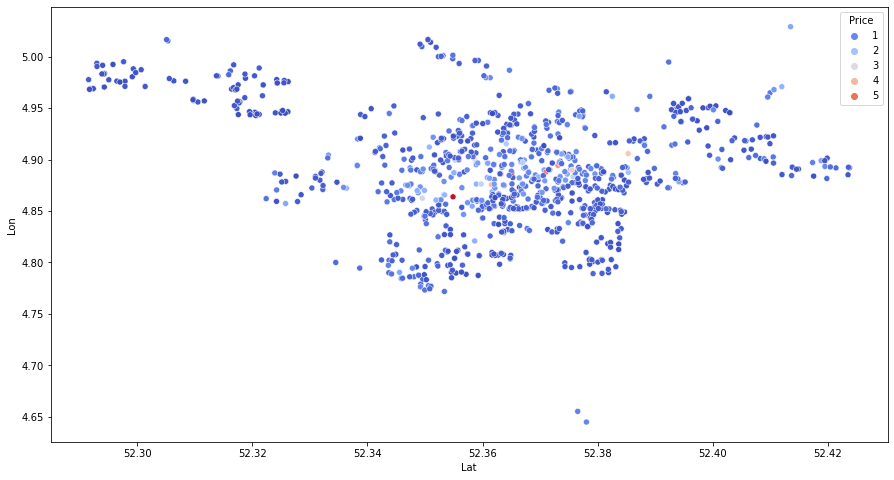

In [8]:
# check for location patterns
plt.figure(figsize=(15,8))
sns.scatterplot(x='Lat',y='Lon',data=data,hue='Price',palette='coolwarm')

In [9]:
# calculate median price per zipcode
median_prices = data.groupby('Zip')['Price'].median()

data = data.merge(median_prices, on='Zip', suffixes=('', '_median'))

data.rename(columns={'Price_median': 'median_price_per_zipcode'}, inplace=True)

In [10]:
# Calculate price per square meter
data['price_per_square_meter'] = data['Price'] / data['Area']

In [11]:
# City center coordinates
city_center = (52.3676, 4.9041)

# Function to calculate distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Calculate distance for each apartment
data['distance_to_city_center'] = data.apply(lambda row: calculate_distance(row['Lat'], row['Lon'], city_center[0], city_center[1]), axis=1)


<AxesSubplot:>

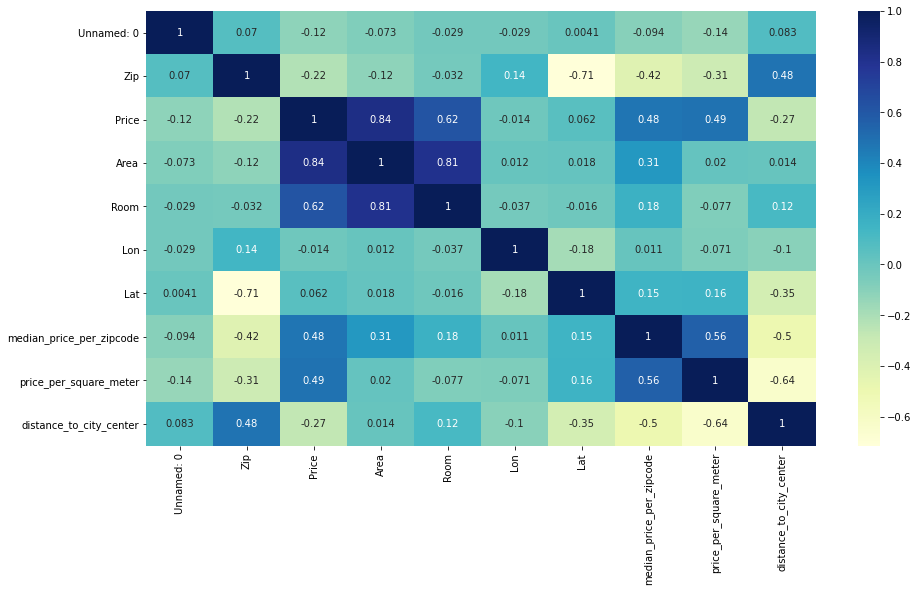

In [12]:
# see what features influence the price most
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")

In [13]:
data.drop(columns=['Address', 'Lat', 'Lon'], inplace=True)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [15]:
X = data.drop(columns=['Price'])  # Exclude the 'Price' column from features
y = data['Price']  # Target variable

# Find rows with NaN or infinite values in y
invalid_indices = np.isnan(y) | np.isinf(y)

# Remove rows with NaN or infinite values from X and y
X_clean = X[~invalid_indices]
y_clean = y[~invalid_indices]

# Train-test split on the cleaned data
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [16]:
# we are using random forest as our predicting model
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor()

In [17]:
forest.score(X_test,y_test)

0.8627735597167681

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# Hyperparameter Tuning to search for the best hyperparameters
forest = RandomForestRegressor()
param_grid= {
    "n_estimators": [100, 200, 300],
    "max_features": [2, 4, 6],
    "min_samples_split": [2, 4, 6, 8],
}
grid_search = GridSearchCV(forest, param_grid, cv=5,
                          scoring = "neg_mean_squared_error",
                          return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
best_forest = grid_search.best_estimator_

In [21]:
#our final accuracy score
best_forest.score(X_test,y_test)

0.8680646880829626

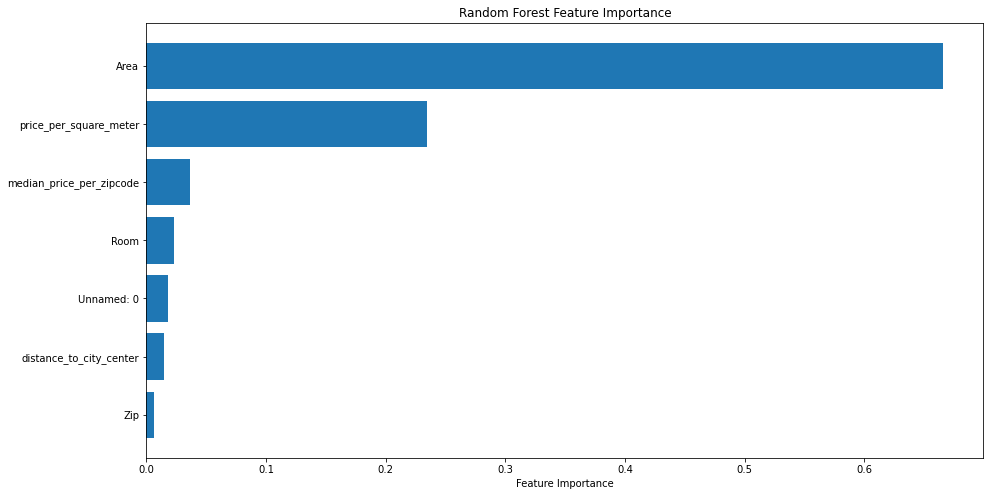

In [22]:
# Visualize feature importance
feature_importance = best_forest.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(15, 8))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()